# 1.1 Word Embedding

In [1]:
import gensim.downloader

# Download the embeddings
w2v = gensim.downloader.load('word2vec-google-news-300')

# 1.2 Data

In [2]:
import time
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adagrad, Adam, RMSprop
from datasets import Dataset

import numpy as np

import matplotlib.pyplot as plt

from seqeval.metrics import f1_score
from seqeval.metrics import classification_report
from seqeval.scheme import IOB1

/mnt/lustre/yuxin/anaconda3/envs/sc4002/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# read data

def read_conll_file(file_path):
    with open(file_path, "r") as f:
        content = f.read().strip()
        sentences = content.split("\n\n")
        data = []
        for sentence in sentences:
            tokens = sentence.split("\n")
            token_data = []
            for token in tokens:
                token_data.append(token.split())
            data.append(token_data)
    return data


train_data = read_conll_file("/mnt/lustre/yuxin/SC4002_G06/datasets/CoNLL2003/eng.train")
validation_data = read_conll_file("/mnt/lustre/yuxin/SC4002_G06/datasets/CoNLL2003/eng.testa")
test_data = read_conll_file("/mnt/lustre/yuxin/SC4002_G06/datasets/CoNLL2003/eng.testb")

In [4]:
# prepare data
def convert_to_dataset(data, label_map):
    formatted_data = {"tokens": [], "ner_tags": []}
    for sentence in data:
        tokens = [token_data[0] for token_data in sentence]
        ner_tags = [label_map[token_data[3]] for token_data in sentence]
        formatted_data["tokens"].append(tokens)
        formatted_data["ner_tags"].append(ner_tags)
    return Dataset.from_dict(formatted_data)


label_list = sorted(list(set([token_data[3] for sentence in train_data for token_data in sentence])))
label_map = {label: i for i, label in enumerate(label_list)}

train_dataset = convert_to_dataset(train_data, label_map)
validation_dataset = convert_to_dataset(validation_data, label_map)
test_dataset = convert_to_dataset(test_data, label_map)

# Dataset Preparation

In [5]:
word2idx = w2v.key_to_index

# Add '<UNK>' and '<PAD>' tokens to the vocabulary index
word2idx['<UNK>'] = len(word2idx)
word2idx['<PAD>'] = len(word2idx)

print(f"word2idx['<UNK>']: {word2idx['<UNK>']}")
print(f"word2idx['<PAD>']: {word2idx['<PAD>']}")

# add the '<UNK>' word to the vocabulary of the Word2Vec model 
# initialize it with the average of all word vectors int he pretrained embeddings.
unk_vector = np.mean(w2v.vectors, axis=0)
w2v.vectors = np.vstack([w2v.vectors, unk_vector])

# add the '<PAD>' word to the vocabulary of the Word2Vec model 
# initialize it with a row of zeros in the vectors matrix.
w2v.vectors = np.vstack([w2v.vectors, np.zeros(w2v.vectors[0].shape)])

word2idx['<UNK>']: 3000000
word2idx['<PAD>']: 3000001


In [6]:
# Map words to Indices
def sentence_to_indices(sentence, vocab):
    return [vocab.get(word, vocab.get('<UNK>')) for word in sentence]

tag2idx = {
    'B-LOC': 0,
    'B-MISC': 1,
    'B-ORG': 2,
    'I-LOC': 3,
    'I-MISC': 4,
    'I-ORG': 5,
    'I-PER': 6,
    'O': 7,
    'PAD': 8
}

class NERDataset(Dataset):
    def __init__(self, sentences, tags, vocab):
        self.sentences = [torch.tensor(sentence_to_indices(sentence, vocab)) for sentence in sentences]
        self.tags = [torch.tensor(tag) for tag in tags]

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx], self.tags[idx]

# Create PyTorch datasets and data loaders
train_dataset = NERDataset(train_dataset['tokens'], train_dataset['ner_tags'], word2idx)
validation_dataset = NERDataset(validation_dataset['tokens'], validation_dataset['ner_tags'], word2idx)
test_dataset = NERDataset(test_dataset['tokens'], test_dataset['ner_tags'], word2idx)

def collate_fn(batch):
    sentences, tags = zip(*batch)
    sentences_padded = pad_sequence(sentences, batch_first=True, padding_value=word2idx['<PAD>'])
    tags_padded = pad_sequence(tags, batch_first=True, padding_value=tag2idx['PAD'])
    return sentences_padded, tags_padded

# 1.3 Model

In [7]:
embedding_matrix = torch.FloatTensor(w2v.vectors)

class BiLSTMNERModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_of_layers, output_dim):
        super(BiLSTMNERModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=word2idx['<PAD>'], freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_of_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        tag_space = self.fc(lstm_out)
        tag_scores = torch.log_softmax(tag_space, dim=-1)
        return tag_scores

# Utilities

In [8]:
EMBEDDING_DIM = w2v[0].shape[0]
VOCAB_SIZE = len(word2idx)
TAGSET_SIZE = len(tag2idx)
MAX_EPOCHS = 50
print(f"EMBEDDING_DIM: {EMBEDDING_DIM}")
print(f"VOCAB_SIZE: {VOCAB_SIZE}")
print(f"TAGSET_SIZE: {TAGSET_SIZE}")

# Hyperparameters
BSET_HIDDEN_DIM = 256
BEST_NUM_LAYERS = 3
OPTIMIZER = RMSprop
LEARNING_RATE = 0.001
BATCH_SIZE = 16

idx2tag = {v: k for k, v in tag2idx.items()}
def idx_to_tags(indices):
    return [idx2tag[idx] for idx in indices]

class EarlyStopper:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.max_f1 = 0

    def early_stop(self, f1):
        if f1 > self.max_f1:
            self.max_f1 = f1
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

EMBEDDING_DIM: 300
VOCAB_SIZE: 3000002
TAGSET_SIZE: 9


In [9]:
def evaluate(model, validation_loader, device):
    print("evaluate.....")
    # Evaluate on the validation dataset
    # Placeholder to store true and predicted tags
    y_true = [] # true tags
    y_pred = [] # predicted tags
        
    # Evaluate the model on the validation dataset
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for sentences, tags in validation_loader:
            # Move the data to the GPU
            sentences, tags = sentences.to(device), tags.to(device)
            tag_scores = model(sentences)
            # print(tag_scores.device)
            predictions = tag_scores.argmax(dim=-1).tolist()
            # print(predictions)
                
            # Convert index to tags
            # Note: filtering out padding tokens
            for sentence, true_seq, pred_seq in zip(sentences, tags.tolist(), predictions):
                valid_length = (sentence != word2idx['<PAD>']).sum().item()
                true_tags = [idx2tag[idx] for idx in true_seq[:valid_length]]
                pred_tags = [idx2tag[idx] for idx in pred_seq[:valid_length]]
                y_true.append(true_tags)
                y_pred.append(pred_tags)
        
    # Compute F1 score
    f1 = f1_score(y_true, y_pred)
    return f1

# Compile

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

# set up model
model = BiLSTMNERModel(EMBEDDING_DIM, BSET_HIDDEN_DIM, BEST_NUM_LAYERS, TAGSET_SIZE).to(device)
loss_function = nn.NLLLoss(ignore_index=tag2idx['PAD']).to(device)
optimizer = OPTIMIZER(model.parameters(), lr=LEARNING_RATE)

Running on device: cuda:0


In [11]:
# Print model structure and parameters
print(model)

BiLSTMNERModel(
  (embedding): Embedding(3000002, 300, padding_idx=3000001)
  (lstm): LSTM(300, 256, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=9, bias=True)
)


# Train

In [13]:
# Initialize dataloaders
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
validation_loader = DataLoader(validation_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Initialize early stopper
early_stopper = EarlyStopper()

# Metrics and checkpoint initialization
best_f1_score = 0
metrics = {'f1': [], 'loss': [], 'epoch_time': []}
total_start_time = time.time()

# Training loop
for epoch in range(MAX_EPOCHS):
    epoch_start_time = time.time()
    
    total_loss = 0
    model.train()  # Make sure the model is in training mode
    for sentences, tags in train_loader:
        sentences, tags = sentences.to(device), tags.to(device)  # Move data to GPU
        model.zero_grad()
        tag_scores = model(sentences)
        loss = loss_function(tag_scores.view(-1, TAGSET_SIZE), tags.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    epoch_loss = total_loss / len(train_loader)
    metrics['loss'].append(epoch_loss)

    f1 = evaluate(model, validation_loader, device)
    metrics['f1'].append(f1)
    
    print(f"Epoch {epoch+1}, loss: {epoch_loss}, f1_score: {f1}")
    
    # Early stopping check
    if early_stopper.early_stop(f1):
        print(f"Stopping early at epoch {epoch+1}")
        break
        
    epoch_time = time.time() - epoch_start_time
    metrics['epoch_time'].append(epoch_time)

    # Save the best model
    # if f1 > best_f1_score:
    #     best_f1_score = f1
    #     best_model_state = model.state_dict()
    #     torch.save(best_model_state, 'best_model.pth')

total_train_time = time.time() - total_start_time
print(f"Total training time: {total_train_time}s")

evaluate.....
Epoch 1, loss: 0.003185664823827511, f1_score: 0.9015526647083508
evaluate.....
Epoch 2, loss: 0.0033340883041139777, f1_score: 0.9044123850501983
evaluate.....
Epoch 3, loss: 0.0028097356891510325, f1_score: 0.9060334629034984
evaluate.....
Epoch 4, loss: 0.002853657932676493, f1_score: 0.9070080862533694
evaluate.....
Epoch 5, loss: 0.0031620242343302165, f1_score: 0.9024102477667285
evaluate.....
Epoch 6, loss: 0.003060637986645806, f1_score: 0.9065539112050741
evaluate.....
Epoch 7, loss: 0.0025221883794955876, f1_score: 0.9020596889449349
evaluate.....
Epoch 8, loss: 0.0028589506877485195, f1_score: 0.9044553616805013
evaluate.....
Epoch 9, loss: 0.002977222643162961, f1_score: 0.90459244195899
Stopping early at epoch 9
Total training time: 76.5036289691925s


In [ ]:
torch.save(model.to('cpu').state_dict(), 'best_model.pth')

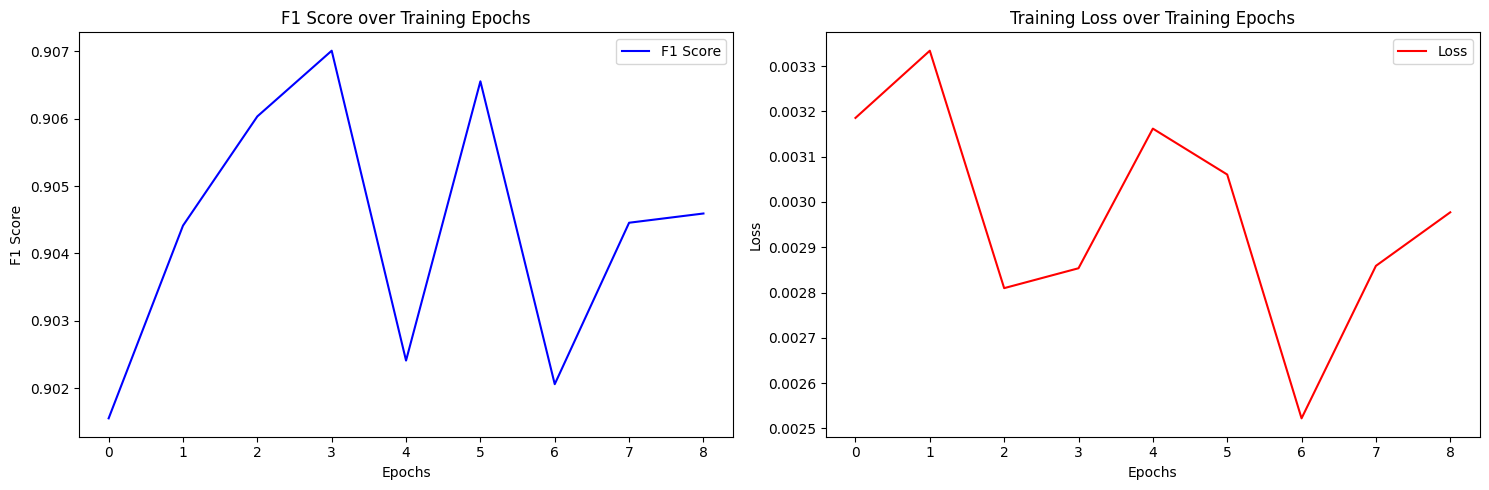

<Figure size 640x480 with 0 Axes>

In [14]:
# Plotting
plt.figure(figsize=(15, 5))

# F1 Score subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(metrics['f1'], label='F1 Score', color='blue')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score over Training Epochs')
plt.legend()

# Training Loss subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(metrics['loss'], label='Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Training Epochs')
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig('train.png')

# Test

In [15]:
# Placeholder to store true and predicted tags for the test set
y_true_test = []
y_pred_test = []

# Evaluate the model on the test dataset
model.eval()  # Set the model to evaluation mode

# Start the clock for timing the test evaluation
start_time = time.time()

with torch.no_grad():
    for sentences, tags in test_loader:
        sentences = sentences.to(device)
        tag_scores = model(sentences)
        predictions = tag_scores.argmax(dim=-1).tolist()
        
        # Convert index to tags
        # Note: filtering out padding tokens
        for sentence, true_seq, pred_seq in zip(sentences, tags.tolist(), predictions):
            valid_length = (sentence != word2idx['<PAD>']).sum().item()
            true_tags = [idx2tag[idx] for idx in true_seq[:valid_length]]
            pred_tags = [idx2tag[idx] for idx in pred_seq[:valid_length]]
            y_true_test.append(true_tags)
            y_pred_test.append(pred_tags)

# Stop the clock after the test evaluation
end_time = time.time()
test_time = end_time - start_time

# Compute F1 score for the test set
f1_test = f1_score(y_true_test, y_pred_test)
report_test = classification_report(y_true_test, y_pred_test)

print("F1 Score on Test Set:", f1_test)
print("Classification Report on Test Set:\n", report_test)
print(f"Test evaluation time: {test_time} seconds")

F1 Score on Test Set: 0.857016064613473
Classification Report on Test Set:
               precision    recall  f1-score   support

         LOC       0.89      0.91      0.90      1668
        MISC       0.75      0.72      0.73       702
         ORG       0.83      0.82      0.82      1661
         PER       0.91      0.89      0.90      1617

   micro avg       0.86      0.85      0.86      5648
   macro avg       0.84      0.84      0.84      5648
weighted avg       0.86      0.85      0.86      5648

Test evaluation time: 0.7636592388153076 seconds


# Inference

In [24]:
def infer(sentence):
    # Tokenize the sentence
    tokens = sentence.split()

    # Convert tokens to indices
    token_indices = torch.tensor([sentence_to_indices(tokens, word2idx)]).to(device)

    # Get predictions from the model
    model.eval()
    with torch.no_grad():
        tag_scores = model(token_indices)
        predictions = tag_scores.argmax(dim=-1).tolist()[0]

    # Convert index to tags
    predicted_tags = idx_to_tags(predictions)

    """
    # Display the results
    for token, tag in zip(tokens, predicted_tags):
        print(f"{token}: {tag}")
    """
    # Prepare aligned output
    token_line = ""
    tag_line = ""
    for token, tag in zip(tokens, predicted_tags):
        space_padding = max(len(token), len(tag)) + 2  # +2 to add some space between words for better readability
        token_line += token.ljust(space_padding)
        tag_line += tag.ljust(space_padding)

    # Display the results
    print(token_line)
    print(tag_line)


# Example usage:
sentence = "EU rejects German call to boycott British lamb ."
sentence = "Barack Obama was born in Hawaii and worked as the President of the United States."
infer(sentence)
print()
sentence = "Jiang Yuxin was born in Shenyang and is now a student in Nanyang Technological University."
infer(sentence)

Barack  Obama  was  born  in  Hawaii  and  worked  as  the  President  of  the  United  States.  
I-PER   I-PER  O    O     O   I-LOC   O    O       O   O    O          O   O    I-ORG   I-ORG    

Jiang  Yuxin  was  born  in  Shenyang  and  is  now  a  student  in  Nanyang  Technological  University.  
I-PER  O      O    O     O   I-LOC     O    O   O    O  O        O   I-LOC    I-LOC          O            
